# Levarage PubChem IDs for predicting CHOP inhibitors

### Content   <a name="content"></a>

1. [Upload and analyse PubChem BioAssay AID 2732 focused on CHOP ](#1)
2. [Create a data frame with CIDs, SIDs and targets](#2)
3. [Upload and analyse PubChem BioAssay AID 1996 on water solubility ](#3)
4. [Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame](#4)
5. [Ensure an equal number of classes in the test sets](#5)
6. [Scaling](#6)
7. [Balancing](#7)
8. [Machine Learning](#8)
9. [Cross validation](#9)
10. [Scrutinise for overfitting](#10)
11. [Hyperparameter tuning](#11)
12. [Final ML model](#12)
13. [Plot the learning curve ans AUC](#13)
14. [Confusion matrix](#14)
15. [Matthews Correlation Coefficient](#15)
16. [Classification report](#16)
17. [LIME analyse](#17)

## Upload and analyse PubChem BioAssay AID 588852 on the M1 receptor antagonists<a name="1"></a>

In [1]:
import pandas as pd 

# load the BioAssay PubChem AID 2732 dataset
# https://pubchem.ncbi.nlm.nih.gov/bioassay/2732
df_targets = pd.read_csv('3.CHOP_PubChem_AID_2732.csv', sep=';')

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df_targets.shape)
df_targets.head()

Shape of the data frame:  (219165, 10)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Pct Inhibition,Luminescence Value
0,1,17416326,2840784.0,CCCCC(=O)NC1=C(C2=C(S1)C(=C(CC2)C=O)Cl)C(=O)OCC,Active,100,NaN,NaN,116.56,35520
1,2,14741113,2010180.0,CC1=CC(=CC=C1)CS(=O)(=O)C2=NN=C(O2)[C@H](CC3=C...,Active,99,NaN,NaN,115.34,69880
2,3,14742004,3696529.0,CC1=CC=C(C=C1)C(=O)C2=C(OC3=C2C(=O)C(=O)C4=CC=...,Active,99,NaN,NaN,115.21,39160
3,4,863128,664366.0,CC[C@@H](C)[C@@H](C1=NN=C(O1)S(=O)(=O)CC2=C(C=...,Active,99,NaN,NaN,114.88,144040
4,5,17409458,6418635.0,C1=CC=C(C=C1)C2=NC(=C(N=N2)C(F)(F)F)SC3=CC=C(C...,Active,98,NaN,NaN,114.24,17400


In [2]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219165 entries, 0 to 219164
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             219165 non-null  int64  
 1   SID                            219165 non-null  int64  
 2   CID                            219164 non-null  float64
 3   PUBCHEM_EXT_DATASOURCE_SMILES  219164 non-null  object 
 4   target                         219165 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         219165 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Pct Inhibition                 219165 non-null  object 
 9   Luminescence Value             219165 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 16.7+ MB


In [3]:
# Remove duplicates 
df_targets.drop_duplicates()
df_targets.shape  # 353737 means no duplicates

(219165, 10)

In [4]:
# Remove compounds with missing CID-s
df_targets = df_targets[df_targets['CID'].notna()]
df_targets.shape

(219164, 10)

In [5]:
# Remove compounds with missing SID-s
df_targets = df_targets[df_targets['SID'].notna()]
df_targets.shape

(219164, 10)

In [6]:
import numpy as np
# Turn CID float data type into integer
df_targets['CID'] = df_targets['CID'].astype(np.int64) 
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219164 entries, 0 to 219164
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             219164 non-null  int64  
 1   SID                            219164 non-null  int64  
 2   CID                            219164 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES  219164 non-null  object 
 4   target                         219164 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         219164 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Pct Inhibition                 219164 non-null  object 
 9   Luminescence Value             219164 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 18.4+ MB


In [7]:
# Analise the Active compounds
df_Active = df_targets[df_targets['target']=='Active']
df_Active.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Pct Inhibition,Luminescence Value
count,8243.000000,8.243000e+03,8.243000e+03,8243,8243,8243.000000,0.0,0.0,8243,8.243000e+03
unique,NaN,NaN,NaN,8241,1,NaN,NaN,NaN,3483,NaN
top,NaN,NaN,NaN,CC1CCC(C(C1)OC(=O)CN2C3=CC=CC=C3[N+](=C2COC4=C...,Active,NaN,NaN,NaN,73.69,NaN
freq,NaN,NaN,NaN,2,8243,NaN,NaN,NaN,12,NaN
mean,4452.646003,1.581319e+07,1.126792e+07,NaN,NaN,75.302560,NaN,NaN,NaN,7.559046e+05
std,8809.378309,7.822437e+06,3.008770e+07,NaN,NaN,10.334771,NaN,NaN,NaN,5.169792e+05
min,1.000000,8.421370e+05,1.318000e+03,NaN,NaN,60.000000,NaN,NaN,NaN,7.480000e+03
25%,2061.500000,1.472127e+07,1.302210e+06,NaN,NaN,66.000000,NaN,NaN,NaN,3.115600e+05
50%,4122.000000,1.741040e+07,2.912244e+06,NaN,NaN,74.000000,NaN,NaN,NaN,6.944800e+05
75%,6182.500000,2.240874e+07,5.393924e+06,NaN,NaN,84.000000,NaN,NaN,NaN,1.134440e+06


In [8]:
# Amalise the Inactive compound
df_Inactive = df_targets[df_targets['target']=='Inactive']
df_Inactive.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Pct Inhibition,Luminescence Value
count,210921.000000,2.109210e+05,2.109210e+05,210921,210921,210921.000000,0.0,0.0,210921,2.109210e+05
unique,NaN,NaN,NaN,210428,1,NaN,NaN,NaN,11216,NaN
top,NaN,NaN,NaN,COC1=C(C=C(C=C1)C2CC(=O)NC2)OC3CCCC3,Inactive,NaN,NaN,NaN,8.???,NaN
freq,NaN,NaN,NaN,4,210921,NaN,NaN,NaN,973,NaN
mean,113691.078333,1.652482e+07,8.292605e+06,NaN,NaN,8.553127,NaN,NaN,NaN,3.268193e+06
std,60887.927275,8.922944e+06,2.363522e+07,NaN,NaN,19.114349,NaN,NaN,NaN,1.372313e+06
min,8231.000000,8.421210e+05,7.200000e+01,NaN,NaN,-501.000000,NaN,NaN,NaN,1.086900e+05
25%,60961.000000,7.970464e+06,1.178186e+06,NaN,NaN,-3.000000,NaN,NaN,NaN,2.251280e+06
50%,113691.000000,1.750500e+07,2.892955e+06,NaN,NaN,7.000000,NaN,NaN,NaN,3.071000e+06
75%,166421.000000,2.480515e+07,5.069751e+06,NaN,NaN,19.000000,NaN,NaN,NaN,4.138920e+06


[<a href="#content">Back to top</a>]

## Create a data frame with CIDs, SIDs and targets <a name="2"></a>

In [9]:
# Create a data frame containing the classification targets
df_targets = df_targets [['CID', 'SID', 'target']]

# Display the data frame
print('Shape of df_targets : ', df_targets .shape)
df_targets .head()

Shape of df_targets :  (219164, 3)


,CID,SID,target
0,2840784,17416326,Active
1,2010180,14741113,Active
2,3696529,14742004,Active
3,664366,863128,Active
4,6418635,17409458,Active


In [10]:
# Check the classes in the bioassay
df_targets['target'].value_counts()

target
Inactive    210921
Active        8243
Name: count, dtype: int64

In [11]:
# Set the binary targets to "1" for an active antagonist and "0" for inactive 
df_targets = df_targets.copy()

# Create a dictionary
targets = {'Active' : 1,
           'Inactive' : 0}

# Replace the names with binary values set up in the dictionary targets
df_targets.target = [targets[item] for item in df_targets.target]

# Check how many unique values there are in the 'target' column
print('Unique values: ', df_targets['target'].unique())

# Count each of the binary targets
df_targets['target'].value_counts()

Unique values:  [1 0]


target
0    210921
1      8243
Name: count, dtype: int64

In [12]:
# Display the data frame
print('Shape of the df_targets: ', df_targets.shape)
df_targets.head()

Shape of the df_targets:  (219164, 3)


,CID,SID,target
0,2840784,17416326,1
1,2010180,14741113,1
2,3696529,14742004,1
3,664366,863128,1
4,6418635,17409458,1


In [13]:
# Creat a dataframe with full set of target 1 for latter use
df_targets_1 = df_targets[df_targets['target']==1]

[<a href="#content">Back to top</a>]

## Upload and analyse PubChem BioAssay AID 1996 on water solubility <a name="3"></a>

In [14]:
# Load data from PubChem BioAssay AID 1996 
df_solubility = pd.read_csv('0.Solubility_pubChem_AID_1996.csv')

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_solubility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57859 entries, 0 to 57858
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   PUBCHEM_RESULT_TAG                                  57859 non-null  int64  
 1   SID                                                 57859 non-null  int64  
 2   CID                                                 57859 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES                       57859 non-null  object 
 4   OUTCOME                                             57859 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE                              57859 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL                                0 non-null      float64
 7   PUBCHEM_ASSAYDATA_COMMENT                           0 non-null      float64
 8   Solubility at pH 7.4_Qualifier_Mean                 57859 non-null  object 


In [16]:
# Create the desired data frame with CID and SID for sifting 
df_solubility = df_solubility[['SID', 'CID']]

# Display the data frame
print('Shape of the data frame: ', df_solubility.shape)
df_solubility.head()

Shape of the data frame:  (57859, 2)


,SID,CID
0,24826444,2374148
1,49669186,5295761
2,49669768,22431387
3,8139962,14296
4,24803435,865684


[<a href="#content">Back to top</a>]

## Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame  <a name="4"></a>

In [17]:
# Sift the main data frame with targets using the solubility data frame 
df = pd.merge(df_targets, df_solubility, on=["CID", "SID"])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (24480, 3)


,CID,SID,target
0,11957207,17401924,1
1,5663704,16952810,1
2,4673185,17504881,1
3,1807333,17388550,1
4,3319616,22414792,1


In [18]:
# Count values of the sifted data frame 
df['target'].value_counts()

target
0    24188
1      292
Name: count, dtype: int64

In [19]:
# Create a data frame with target 0
df_0 = df[df['target']==0]

# Concatenate the sifted target 0 with the original target 1
df = pd.concat([df_0, df_targets_1])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (32431, 3)


,CID,SID,target
292,2812961,26731633,0
293,2209576,24788363,0
294,2811845,26728765,0
295,3624322,24838072,0
296,2414029,24825712,0


In [20]:
df.to_csv("HF_human_M1_muscarinic_receptor_antagonists_CID_SID.csv", index=False)
# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (32431, 3)


,CID,SID,target
292,2812961,26731633,0
293,2209576,24788363,0
294,2811845,26728765,0
295,3624322,24838072,0
296,2414029,24825712,0


In [21]:
# Count the target
df['target'].value_counts()

target
0    24188
1     8243
Name: count, dtype: int64

In [22]:
# Shuffle the resulting data set
df = df.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

[<a href="#content">Back to top</a>]

## Ensure an equal number of classes in the test sets <a name="5"></a>

In [23]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract samples for the test set
df_1_test = df_1.iloc[:3250]  # with 8+4.5 samples nad 1300 XGBoost	0.831	0.869	0.778	0.821	0.831

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[3250:]

In [24]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract for the test set
df_0_test = df_0.iloc[:3250]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[3250:]

In [25]:
df_0.shape

(24188, 3)

In [26]:
# Create train and test dataframe for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [27]:
# Create the sets for ML 
X_train = train.drop(columns='target', axis=1)
y_train = train['target']
X_test =  test.drop(columns='target', axis=1)
y_test = test['target']

In [28]:
type(X_train)

pandas.core.frame.DataFrame

In [29]:
# Create the sets for Cross-validation
X = pd.concat([X_train, X_test])
y = pd.concat([y_train,y_test])

In [30]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
0    3250
1    3250
Name: count, dtype: int64

In [31]:
# Keeping sets for the cross validation  
X_cv = X_train.reset_index(drop=True)
y_cv = y_train.reset_index(drop=True)

# for LIME analyse
feature_names = list(X_train.columns)

[<a href="#content">Back to top</a>]

## Scaling <a name="6"></a>

In [32]:
import time

# Record the start time
start_time = time.time()

In [33]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# # Standardise the data points
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (25931, 2)
X_test:   (6500, 2)
y_train:  (25931,)
y_test:   (6500,)


[<a href="#content">Back to top</a>]

## Balancing <a name="7"></a>

[(0, 20938), (1, 4993)]


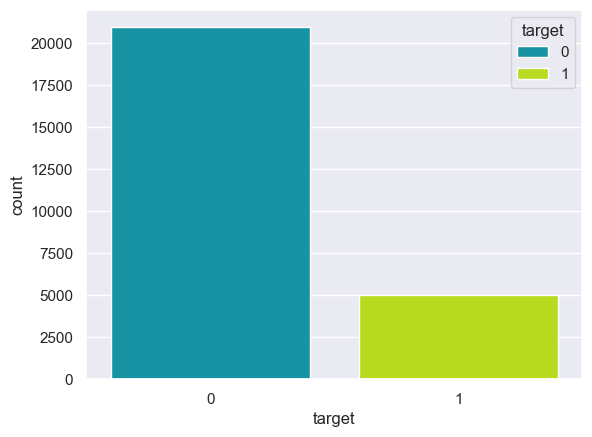

In [35]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 20938), (1, 20938)]


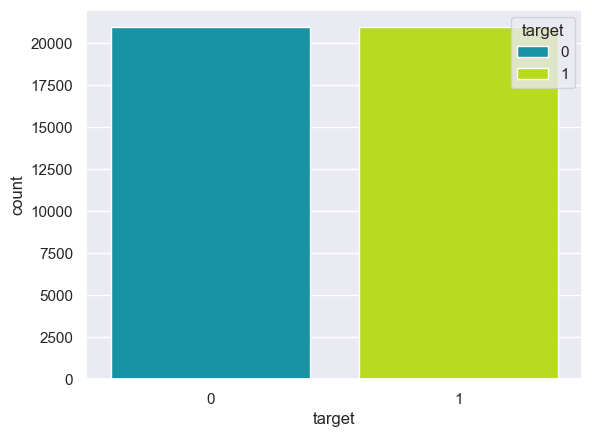

In [36]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [37]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (41876, 2)
X_test:   (6500, 2)
y_train:  (41876,)
y_test:   (6500,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="8"></a>

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the estimator 
model = GradientBoostingClassifier(random_state=42)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.902
Precision:  0.983
Recall:  0.818
F1:  0.893
ROC:  0.902


In [39]:
# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

Time elapsed: 5.1553 seconds


In [40]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the algorithms that will be used, placing them in a dictionary 
clfs = {"SVM":SVC(kernel='rbf', C=1, probability=True),
        "Decision":DecisionTreeClassifier(), 
        "RandomForest":RandomForestClassifier(), 
        "GradientBoost":GradientBoostingClassifier(),
        "XGBoost":XGBClassifier(verbosity=0),
       "K-nearest": KNeighborsClassifier(n_neighbors=3)
       }

In [41]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create statistics with the results of training with different algorithms
def model_fit(clfs):
    fitted_model={}
    model_result = pd.DataFrame()
    # Iterate the clfs dictionary clfs
    for model_name, model in clfs.items():
        # Train the current model
        model.fit(X_train,y_train)
        # Add the current model name
        fitted_model.update({model_name:model})
        # Prediction of the current model 
        y_pred = model.predict(X_test)
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        # Calculate the metrics
        model_dict['2.Accuracy'] = round(accuracy_score(y_test, y_pred),3)
        model_dict['3.Precision'] = round(precision_score(y_test, y_pred),3)
        model_dict['4.Recall'] = round(recall_score(y_test, y_pred),3)
        model_dict['5.F1'] = round(f1_score(y_test, y_pred),3)
        model_dict['6.ROC'] = round(roc_auc_score(y_test, y_pred),3)
        model_result = model_result._append(model_dict,ignore_index=True)
    return fitted_model, model_result

# Run the function model_fit(clfs) 
fitted_model, model_result = model_fit(clfs)

# Display the results of the model_fit(clfs) function in a descending order
model_result.sort_values(by=['2.Accuracy'],ascending=False)

,1.Algorithm,2.Accuracy,3.Precision,4.Recall,5.F1,6.ROC
3,GradientBoost,0.902,0.983,0.818,0.893,0.902
4,XGBoost,0.897,0.961,0.827,0.889,0.897
2,RandomForest,0.893,0.966,0.814,0.884,0.893
0,SVM,0.884,0.980,0.784,0.871,0.884
1,Decision,0.883,0.955,0.804,0.873,0.883
5,K-nearest,0.876,0.909,0.837,0.871,0.876


In [42]:
model_result.to_csv("ML_CHOP.csv", index=False)

[<a href="#content">Back to top</a>]

## Cross-validation  <a name="9"></a>

In [44]:
# Five-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

# Define the Model
model = GradientBoostingClassifier(random_state=42)

# Number of folds
n_splits = 5

# Stratified K-Fold ensures balanced class distribution in each fold
# This ensures that each training and test fold has a similar percentage of class 1.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics from each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# --- 3. Cross-Validation Loop with Manual SMOTE Resampling ---
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with Manual SMOTE...\n")

# Initialize the SMOTE object once
# smote= SMOTE(random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")

    # Split data for the current fold
    X_train_cv, X_test_cv = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train_cv, y_test_cv = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Report class distributions before resampling
    print(f"  Training set class distribution (Original): {np.bincount(y_train_cv)}")
    print(f"  Test set class distribution: {np.bincount(y_test_cv)}")

    # Apply SMOTE oversampling on the training split only
    # This is the step that replaces the imblearn pipeline logic.
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_cv, y_train_cv)
    print(f"  Training set (after SMOTE) class distribution: {np.bincount(y_train_resampled)}")

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the *original, untouched* test data
    y_pred_cv = model.predict(X_test_cv)
    # Get probabilities for ROC AUC calculation
    y_prob_cv = model.predict_proba(X_test_cv)[:, 1]

    # Evaluate performance for the current fold
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv, zero_division=0)
    recall = recall_score(y_test_cv, y_pred_cv, zero_division=0)
    f1 = f1_score(y_test_cv, y_pred_cv, zero_division=0)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Store scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred_cv)}\n")
    print("-" * 30)


# --- 4. Aggregate and Report Final Metrics ---
print("\n--- Cross-Validation Results Summary ---")

# Convert lists to NumPy arrays for easier statistical manipulation
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
roc_auc_scores = np.array(roc_auc_scores)

print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")
print("\n--- Summary ---")
print("The standard deviation (+/-) indicates the stability of the model performance across the different folds.")

Performing 5-Fold Stratified Cross-Validation with Manual SMOTE...

--- Fold 1/5 ---
  Training set class distribution (Original): [16750  3994]
  Test set class distribution: [4188  999]
  Training set (after SMOTE) class distribution: [16750 16750]
  Accuracy: 0.9543
  Precision: 0.9168
  Recall (Sensitivity): 0.8388
  F1-Score: 0.8761
  ROC AUC: 0.9487
  Confusion Matrix:
[[4112   76]
 [ 161  838]]

------------------------------
--- Fold 2/5 ---
  Training set class distribution (Original): [16750  3995]
  Test set class distribution: [4188  998]
  Training set (after SMOTE) class distribution: [16750 16750]
  Accuracy: 0.9524
  Precision: 0.9113
  Recall (Sensitivity): 0.8337
  F1-Score: 0.8707
  ROC AUC: 0.9411
  Confusion Matrix:
[[4107   81]
 [ 166  832]]

------------------------------
--- Fold 3/5 ---
  Training set class distribution (Original): [16750  3995]
  Test set class distribution: [4188  998]
  Training set (after SMOTE) class distribution: [16750 16750]
  Accuracy:

[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="11"></a>

In [45]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.890, test: 0.892
>2, train: 0.896, test: 0.897
>3, train: 0.901, test: 0.902
>4, train: 0.905, test: 0.901
>5, train: 0.913, test: 0.901
>6, train: 0.922, test: 0.900
>7, train: 0.933, test: 0.897
>8, train: 0.946, test: 0.894
>9, train: 0.956, test: 0.897
>10, train: 0.966, test: 0.895
>11, train: 0.983, test: 0.898
>12, train: 0.987, test: 0.896
>13, train: 0.996, test: 0.896
>14, train: 0.997, test: 0.896
>15, train: 1.000, test: 0.897
>16, train: 1.000, test: 0.897
>17, train: 1.000, test: 0.896
>18, train: 1.000, test: 0.896
>19, train: 1.000, test: 0.895
>20, train: 1.000, test: 0.894


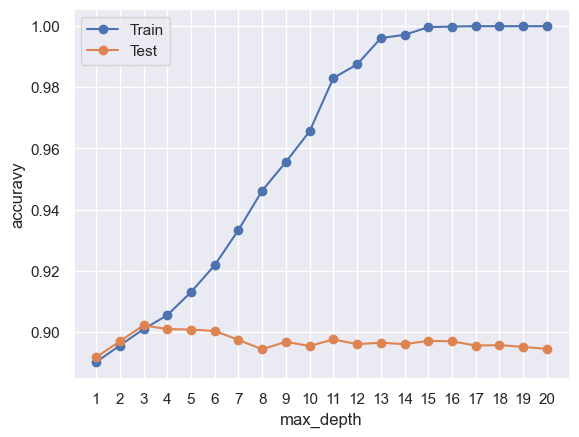

In [47]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Hyperparameter tuning  <a name="11"></a>

In [49]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5],
    'min_samples_leaf': [1, 5],
    'subsample': [0.8, 1.0]
}

# Create the model
model = GradientBoostingClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                          cv=5, scoring='accuracy', verbose=2) 
grid_search.fit(X_train, y_train) 

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time=   4.2s
[CV] END learning_rate=0.0

In [56]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i,
                        learning_rate=0.2,
                        min_samples_leaf=1,
                        n_estimators=300,
                        subsample=0.8)
 # fit model_ on the trg dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.892, test: 0.894
>2, train: 0.910, test: 0.901
>3, train: 0.929, test: 0.899
>4, train: 0.955, test: 0.898
>5, train: 0.973, test: 0.894
>6, train: 0.991, test: 0.892
>7, train: 0.998, test: 0.893
>8, train: 1.000, test: 0.891
>9, train: 1.000, test: 0.891
>10, train: 1.000, test: 0.894
>11, train: 1.000, test: 0.895
>12, train: 1.000, test: 0.896
>13, train: 1.000, test: 0.897
>14, train: 1.000, test: 0.899
>15, train: 1.000, test: 0.897
>16, train: 1.000, test: 0.896
>17, train: 1.000, test: 0.896
>18, train: 1.000, test: 0.897
>19, train: 1.000, test: 0.897
>20, train: 1.000, test: 0.896


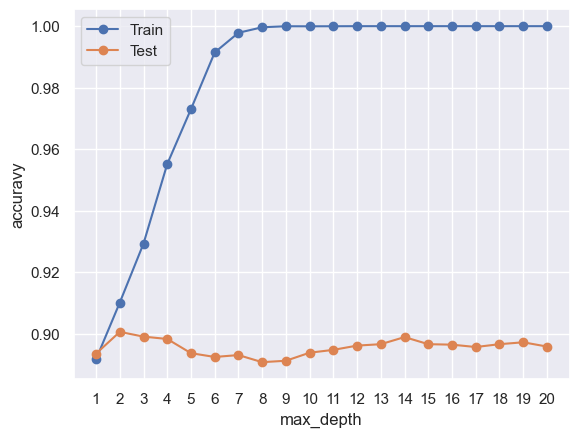

In [57]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [58]:
# ML with the suggested hyperparameters 
model = GradientBoostingClassifier(max_depth=3,
                        learning_rate=0.2,
                        min_samples_leaf=1,
                        n_estimators=300,
                        subsample=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.899
Precision:  0.974
Recall:  0.82
F1:  0.89
ROC:  0.899


In [64]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'max_depth': 3,
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    model = GradientBoostingClassifier(**params)
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize') 

# Run the optimization
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model =  GradientBoostingClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[I 2025-11-26 19:09:26,083] A new study created in memory with name: no-name-91dedb3f-9b09-4cea-a93e-b616dffb57ce
[I 2025-11-26 19:10:00,299] Trial 0 finished with value: -0.9052440719040898 and parameters: {'n_estimators': 250, 'learning_rate': 0.11243870727659287, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.8839564282309883}. Best is trial 0 with value: -0.9052440719040898.
[I 2025-11-26 19:10:18,154] Trial 1 finished with value: -0.8997755834010464 and parameters: {'n_estimators': 150, 'learning_rate': 0.06958471230840091, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7283193572458988}. Best is trial 0 with value: -0.9052440719040898.
[I 2025-11-26 19:11:07,565] Trial 2 finished with value: -0.9053873526351053 and parameters: {'n_estimators': 450, 'learning_rate': 0.060709373719802756, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6638331241356379}. Best is trial 2 with value: -0.9053873526351053.
[I 2025-11-26 19:11:40,136] Trial 3 

Best Accuracy: 0.9009230769230769
Best Hyperparameters: {'n_estimators': 450, 'learning_rate': 0.17614958245232423, 'min_samples_split': 11, 'min_samples_leaf': 7, 'subsample': 0.8625659634863001}


In [65]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
# model_ = RandomForestClassifier(max_depth=i)
 model_ = GradientBoostingClassifier(max_depth=i,
                                    learning_rate=0.17614958245232423,
                                    min_samples_leaf=7,
                                    n_estimators=450,
                                    subsample=0.8625659634863001,
                                    min_samples_split=11)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.891, test: 0.894
>2, train: 0.914, test: 0.900
>3, train: 0.931, test: 0.902
>4, train: 0.955, test: 0.899
>5, train: 0.974, test: 0.899
>6, train: 0.987, test: 0.901
>7, train: 0.994, test: 0.898
>8, train: 0.997, test: 0.902
>9, train: 0.999, test: 0.899
>10, train: 0.999, test: 0.899
>11, train: 1.000, test: 0.899
>12, train: 1.000, test: 0.897
>13, train: 1.000, test: 0.897
>14, train: 1.000, test: 0.897
>15, train: 1.000, test: 0.894
>16, train: 1.000, test: 0.897
>17, train: 1.000, test: 0.896
>18, train: 1.000, test: 0.895
>19, train: 1.000, test: 0.896
>20, train: 1.000, test: 0.895


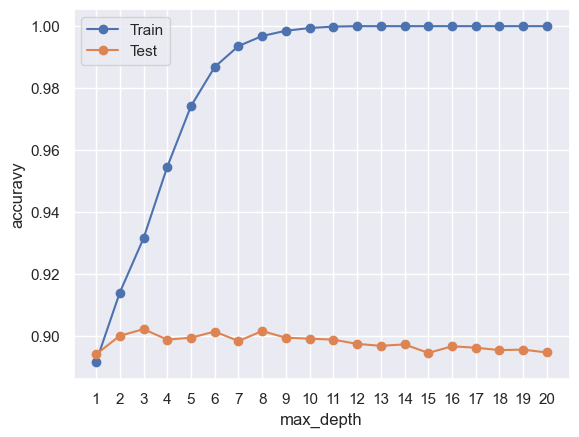

In [66]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [67]:
# ML with the suggested hyperparameters 
model = GradientBoostingClassifier(max_depth=3,
                                    learning_rate=0.17614958245232423,
                                    min_samples_leaf=7,
                                    n_estimators=450,
                                    subsample=0.8625659634863001,
                                    min_samples_split=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.9
Precision:  0.97
Recall:  0.826
F1:  0.892
ROC:  0.9


[<a href="#content">Back to top</a>]

## Final ML model  <a name="12"></a>

In [72]:
# ML with the suggested hyperparameters 
model = GradientBoostingClassifier(max_depth=3,
                                  learning_rate=0.17614958245232423,
                                  min_samples_leaf=7,
                                  n_estimators=450,
                                  subsample=0.8625659634863001,
                                  min_samples_split=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.901
Precision:  0.973
Recall:  0.826
F1:  0.893
ROC:  0.901


[<a href="#content">Back to top</a>]

## Plot the learning curve and AUC <a name="13"></a>

C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ivano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ivano\AppDat

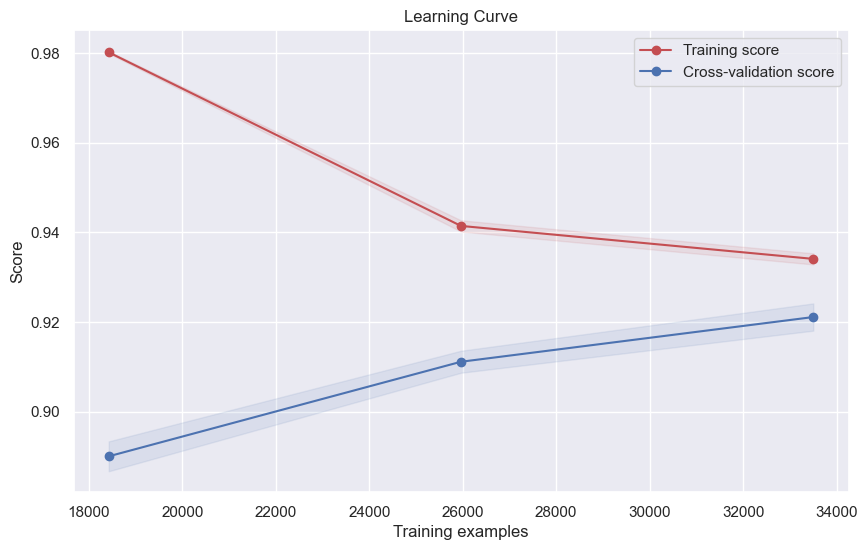

In [74]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

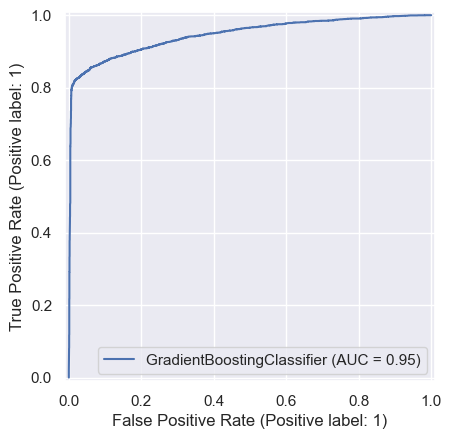

In [75]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix<a name="14"></a>

[2683, 3175, 75, 567]

--- Classification Metrics ---
True Positives (TP): 2683
True Negatives (TN): 3175
False Positives (FP): 75
False Negatives (FN): 567
----------------------------



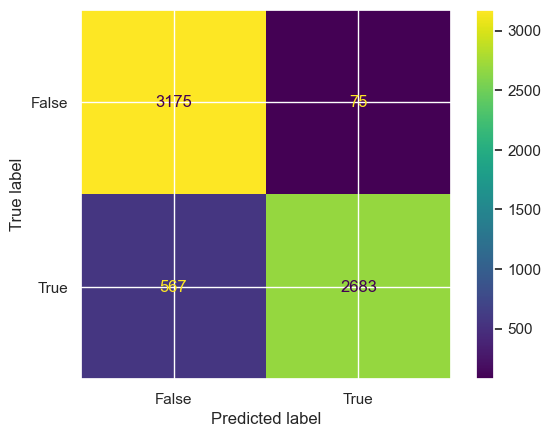

In [76]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# # Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN 
# Use .ravel() to flatten the 2x2 matrix into a 1x4 array: [TN, FP, FN, TP]
TN, FP, FN, TP = confusion_matrix.ravel()
conf_matrix_list = [TP, TN, FP, FN]

# Print the list with metrics
print(conf_matrix_list)

# Print the metrics
print("\n--- Classification Metrics ---")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print("----------------------------\n")

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[<a href="#content">Back to top</a>]

## Matthews Correlation Coefficient <a name="15"></a>

In [77]:
import math

def matthews_corr_coeff(TP: int, TN: int, FP: int, FN: int) -> float:
    """
    Calculates the Matthews Correlation Coefficient (MCC).

    MCC is a metric used to evaluate the quality of binary classifications.
    It takes into account true positives, true negatives, false positives, 
    and false negatives, making it a reliable measure even for imbalanced classes.

    The formula is:
    MCC = (TP * TN - FP * FN) / sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

    Args:
        TP (int): True Positives (correctly predicted positive cases).
        TN (int): True Negatives (correctly predicted negative cases).
        FP (int): False Positives (incorrectly predicted positive cases).
        FN (int): False Negatives (incorrectly predicted negative cases).

    Returns:
        float: The Matthews Correlation Coefficient, ranging from -1 (worst) 
               to +1 (best). Returns 0.0 if the denominator is zero.
    """
    
    # Calculate the numerator: (TP * TN) - (FP * FN)
    numerator = (TP * TN) - (FP * FN)
    
    # Calculate the components of the denominator
    # Note: These components are the marginal sums (sums of rows/columns in the confusion matrix)
    term_1 = TP + FP
    term_2 = TP + FN
    term_3 = TN + FP
    term_4 = TN + FN
    
    # Calculate the denominator: sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))
    denominator = math.sqrt(term_1 * term_2 * term_3 * term_4)
    
    # Handle the case where the denominator is zero (which means one of the marginal
    # sums is zero, indicating an ill-defined problem or a trivial prediction). 
    # In this case, MCC is conventionally set to 0.
    if denominator == 0:
        print("Warning: Denominator is zero. Returning MCC = 0.0")
        return 0.0
    
    # Calculate the final MCC value
    mcc = numerator / denominator
    return mcc

# tp1, tn1, fp1, fn1 = [9090, 6115, 1966, 3201]
tp1, tn1, fp1, fn1 = conf_matrix_list
mcc1 = matthews_corr_coeff(tp1, tn1, fp1, fn1)
print(f"---  Model ---")
print(f"TP={tp1}, TN={tn1}, FP={fp1}, FN={fn1}")
print(f"MCC: {mcc1:.4f}\n")

---  Model ---
TP=2683, TN=3175, FP=75, FN=567
MCC: 0.8118



[<a href="#content">Back to top</a>]

## Classification report <a name="16"></a>

In [78]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.85      0.98      0.91      3250
Inactive (target 0)       0.97      0.83      0.89      3250

           accuracy                           0.90      6500
          macro avg       0.91      0.90      0.90      6500
       weighted avg       0.91      0.90      0.90      6500



[<a href="#content">Back to top</a>]

## Model robustness check <a name="17"></a>

In [89]:
model = GradientBoostingClassifier(max_depth=3,
                                    learning_rate=0.17614958245232423,
                                    min_samples_leaf=7,
                                    n_estimators=450,
                                    subsample=0.8625659634863001,
                                    min_samples_split=11)
model.fit(X_train, y_train)

# Calculate baseline accuracy on the clean, un-noised/un-imputed test set (NumPy version)
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))

print(f"Baseline Accuracy on clean test data: {baseline_accuracy:.4f}\n")
all_accuracy_scores = [] # List to store all individual noisy/imputed accuracies


Baseline Accuracy on clean test data: 0.9017



In [91]:
# Gausian nose robustness test
def add_gaussian_noise(data, noise_level=0.1):
    """Adds Gaussian noise to a dataset (NumPy array assumed)."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

noise_levels_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

print("--- Running Gaussian Noise Robustness Test ---")
for noise_level in noise_levels_to_test:
    # Add Gaussian noise to the test set (using NumPy array)
    X_test_noisy = add_gaussian_noise(X_test, noise_level=noise_level)

    # Make predictions and calculate accuracy
    y_pred_noisy = model.predict(X_test_noisy)
    noisy_accuracy = accuracy_score(y_test, y_pred_noisy)

    all_accuracy_scores.append(noisy_accuracy)

    print(f"Level {noise_level:.1f}: Accuracy={noisy_accuracy:.4f}, Loss={baseline_accuracy - noisy_accuracy:.4f}")

--- Running Gaussian Noise Robustness Test ---
Level 0.1: Accuracy=0.6432, Loss=0.2585
Level 0.2: Accuracy=0.5931, Loss=0.3086
Level 0.3: Accuracy=0.5700, Loss=0.3317
Level 0.4: Accuracy=0.5548, Loss=0.3469
Level 0.5: Accuracy=0.5469, Loss=0.3548
Level 0.6: Accuracy=0.5438, Loss=0.3578


In [92]:
from sklearn.impute import SimpleImputer

# Missing values robustness test
def introduce_missing_values(data, missing_rate=0.1):
    """Introduces a specified rate of missing values (np.nan) into a dataset."""
    if isinstance(data, pd.DataFrame):
        data = data.values

    data_missing = data.copy().astype(float)
    num_missing = int(np.ceil(data.size * missing_rate))
    indices = np.random.choice(data.size, num_missing, replace=False)
    data_missing.flat[indices] = np.nan
    return data_missing

missing_rates = [0.1, 0.2, 0.3, 0.4]

print("\n--- Running Missing Value Robustness Test (Imputation) ---")

# We must fit the imputer on the training data (X_train_np) only once!
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train)

for rate in missing_rates:
    # Introduce missing values in the test set (using NumPy array)
    X_test_missing = introduce_missing_values(X_test, missing_rate=rate)

    # Transform (impute) the missing data
    X_test_imputed = imputer.transform(X_test_missing)

    # Make predictions and calculate accuracy
    y_pred_imputed = model.predict(X_test_imputed)
    imputed_accuracy = accuracy_score(y_test, y_pred_imputed)

    all_accuracy_scores.append(imputed_accuracy)

    robustness_loss = baseline_accuracy - imputed_accuracy
    print(f"Rate {rate:.1f}: Accuracy={imputed_accuracy:.4f}, Loss={robustness_loss:.4f}")


--- Running Missing Value Robustness Test (Imputation) ---
Rate 0.1: Accuracy=0.8575, Loss=0.0442
Rate 0.2: Accuracy=0.8174, Loss=0.0843
Rate 0.3: Accuracy=0.7705, Loss=0.1312
Rate 0.4: Accuracy=0.7326, Loss=0.1691


In [93]:
# Overall average robustness calculation
num_tests = len(all_accuracy_scores)
overall_average_robustness = np.mean(all_accuracy_scores)

print(f"Total Robustness Tests Conducted: {num_tests}")
print(f"Overall Average Robustness (Accuracy): {overall_average_robustness:.4f}")
print("This metric represents the average accuracy the model maintained across all defined degradation scenarios.")

Total Robustness Tests Conducted: 16
Overall Average Robustness (Accuracy): 0.6303
This metric represents the average accuracy the model maintained across all defined degradation scenarios.


[<a href="#content">Back to top</a>]

## LIME analyse <a name="17"></a>

In [111]:
from lime.lime_tabular import LimeTabularExplainer

# Check and define feature/class names
FEATURE_COLUMNS = feature_names
TARGET_CLASSES = ['Class 0', 'Class 1']

# Verification
print("--- Data Check ---")
print(f"X_train shape: {X_train.shape}")
print("-" * 30)

# Model Training Function 
def train_svc_model(X_train_data, y_train_data):
    """Trains a Support Vector Classifier."""
    model= GradientBoostingClassifier(max_depth=3,
                                    learning_rate=0.17614958245232423,
                                    min_samples_leaf=7,
                                    n_estimators=450,
                                    subsample=0.8625659634863001,
                                    min_samples_split=11)
    model.fit(X_train_data, y_train_data)
    return model

# Train the model
model = train_svc_model(X_train, y_train)

# Model Evaluation
print(f"Model Accuracy: {model.score(X_test, y_test):.4f}")
print("-" * 30)

# Initialize LIME Explainer
# Use X_train.values (NumPy array) for training_data for LimeTabularExplainer's optimal performance
explainer = LimeTabularExplainer(
    training_data=X_train, # Use NumPy array for LIME training_data
    feature_names=FEATURE_COLUMNS,
    class_names=TARGET_CLASSES,
    mode='classification',
    discretize_continuous=True,
    random_state=42 # Add random state for reproducibility
)

print("LIME Explainer Initialized.")
print("-" * 30)

# Explain a Single Prediction
instance_idx = 3
# Get the instance as a NumPy array for LIME explanation
explanation_instance_np = X_test[instance_idx] 
true_label = y_test[instance_idx].iloc[0]

# Define the model's prediction function
prediction_function = model.predict_proba

print(f"Explaining instance index: {instance_idx}")
print(f"True Label: {true_label}")
# Reshape for single prediction if needed, though model.predict usually handles 1-row array
predicted_class = model.predict(explanation_instance_np.reshape(1, -1))[0]
print(f"Model Prediction (Class): {predicted_class}")
print("-" * 30)

# Generate the explanation
# LIME requires the instance data_row to be a NumPy array
exp = explainer.explain_instance(
    data_row=explanation_instance_np,
    predict_fn=prediction_function,
    num_features=5, # Increased number of features for a richer explanation
    num_samples=1000 # Default/common value for robustness
)

# Interpret the Explanation
print("LIME Explanation (Top features and their influence):")
print(exp.as_list())

--- Data Check ---
X_train shape: (41876, 2)
------------------------------
Model Accuracy: 0.9011
------------------------------
LIME Explainer Initialized.
------------------------------
Explaining instance index: 3
True Label: 0
Model Prediction (Class): 0
------------------------------
LIME Explanation (Top features and their influence):
[('-1.08 < SID <= 0.24', 0.5525200658672043), ('-0.26 < CID <= -0.17', 0.005272437955820823)]


[<a href="#content">Back to top</a>]